# Code is split into 2 main parts 
# 1. Data Science (preprocessing and feature engineering)
# 2. Artificial Intellegience (modelling using logistic regression and CNN*)
*requires more computing resources

# INPUT FILES: mzml format files in their separated compound folders
# - mzml files were converted from D files, using msconvert application, which were directly extracted from GCMS 4's masshunter application.

In [4]:
import pyteomics
import pandas as pd
import time
from pyteomics import mzml
import itertools
from pathlib import Path
from pprint import pprint
import os
import shutil
import random
import re

from matplotlib import pyplot as plt, cm
import numpy as np
from pandas_path import path
from PIL import Image
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm

RANDOM_SEED = 42  # For reproducibility
tqdm.pandas()

# Start of preprocessing 

In [5]:
# Get the mzml directory
data_directory = os.path.join(os.getcwd(), 'data')
mzml_directory = os.path.join(data_directory, 'MZML Data', 'BHT')

# Mentioned further down as well, online literature normalises against the entire sample run
Code in specific: 'normalised intensity': intensity/max(intensity_values)


In [6]:
# Initialize variables for tracking iterations and total execution time
iteration_count = 0
total_execution_time = 0

# Iterate through all files in the mzml directory
for file in os.listdir(mzml_directory):
    if file.endswith(".mzML"):
        # Load the mzML file
        mzml_file = os.path.join(mzml_directory, file)

        # Start the timer
        start_time = time.time()

        # Create a list to store dictionaries representing rows in the DataFrame
        rows = []

        with mzml.read(mzml_file) as reader:
            scan_number = 1
            for spectrum in reader:
                mz_values = spectrum['m/z array']
                intensity_values = spectrum['intensity array']
                scan_time = spectrum['scanList']['scan'][0]['scan start time']
                tic = spectrum['total ion current']

                # Iterate over the mz_values and intensity_values lists
                for mz, intensity in zip(mz_values, intensity_values):
                    # Create a dictionary representing a row in the DataFrame
                    row = {'scan number': scan_number, 'scan time': scan_time, 'total ion current': tic, 
                           'm/z': mz, 'intensity': intensity, 'normalised intensity': intensity/max(intensity_values), 
                          'rounded m/z': round(mz)} 
                    rows.append(row)

                scan_number += 1
        # Create DataFrame from the list of dictionaries
        df_extracted = pd.DataFrame(rows)

        # Save the extracted DataFrame as an Excel file with a unique name
        cleaned_data_file = os.path.splitext(file)[0] + "_cleaned.xlsx"
        cleaned_data_path = os.path.join(mzml_directory, cleaned_data_file)
        df_extracted.to_excel(cleaned_data_path, index=True)

        # Calculate the iteration execution time
        iteration_time = time.time() - start_time

        # Update iteration count and total execution time
        iteration_count += 1
        total_execution_time += iteration_time

        print(f"Iteration {iteration_count}: Processed {file} in {iteration_time:.2f} seconds and saved the cleaned data in {cleaned_data_file}.")

# Print the final summary
print(f"\nTotal iterations: {iteration_count}")
print(f"Total execution time: {total_execution_time:.2f} seconds.")

Iteration 1: Processed BHT 1.mzML in 51.23 seconds and saved the cleaned data in BHT 1_cleaned.xlsx.
Iteration 2: Processed BHT 10.mzML in 52.32 seconds and saved the cleaned data in BHT 10_cleaned.xlsx.
Iteration 3: Processed BHT 11.mzML in 54.85 seconds and saved the cleaned data in BHT 11_cleaned.xlsx.
Iteration 4: Processed BHT 12 .mzML in 42.67 seconds and saved the cleaned data in BHT 12 _cleaned.xlsx.
Iteration 5: Processed BHT 13.mzML in 29.60 seconds and saved the cleaned data in BHT 13_cleaned.xlsx.
Iteration 6: Processed BHT 14.mzML in 24.06 seconds and saved the cleaned data in BHT 14_cleaned.xlsx.
Iteration 7: Processed BHT 15.mzML in 27.15 seconds and saved the cleaned data in BHT 15_cleaned.xlsx.
Iteration 8: Processed BHT 16.mzML in 25.24 seconds and saved the cleaned data in BHT 16_cleaned.xlsx.
Iteration 9: Processed BHT 17.mzML in 27.08 seconds and saved the cleaned data in BHT 17_cleaned.xlsx.
Iteration 10: Processed BHT 18.mzML in 21.19 seconds and saved the cleane

# Repeat for all samples by changing the file name

In [32]:
# Define the source and destination folders
source_folder = os.path.join(data_directory, 'MZML DATA', 'DBEEA&BHT')
destination_folder = os.path.join(data_directory, 'all_features')

# Create the "master list" folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Get the list of Excel files in the source folder
excel_files = [file for file in os.listdir(source_folder) if file.endswith('.xlsx')]

# Determine the starting sample number
if excel_files:
    last_sample_number = 0
    for file in excel_files:
        try:
            sample_number = int(file.split('_')[-1].split('.')[0])
            if sample_number > last_sample_number:
                last_sample_number = sample_number
        except ValueError:
            continue
    start_sample_number = last_sample_number + 1
else:
    start_sample_number = 1

# List to store the names of created files
created_files = []

# Iterate over the Excel files and copy them to the destination folder
for file in excel_files:
    source_path = os.path.join(source_folder, file)
    destination_name = ''
    while True:
        destination_name = f'sample_{start_sample_number:06}.xlsx'
        destination_path = os.path.join(destination_folder, destination_name)

        # Check if the destination file already exists
        if not os.path.exists(destination_path):
            break

        start_sample_number += 1

    shutil.copyfile(source_path, destination_path)
    created_files.append(destination_name)  # Append the created file name to the list
    print(f"File '{file}' copied to '{destination_name}'")
    start_sample_number += 1

print("Created files:")
for file_name in created_files:
    print(file_name)

File 'DBEEA & BHT Mixture 1_cleaned.xlsx' copied to 'sample_000294.xlsx'
File 'DBEEA & BHT Mixture 2_cleaned.xlsx' copied to 'sample_000295.xlsx'
File 'DBEEA & BHT Mixture 3_cleaned.xlsx' copied to 'sample_000296.xlsx'
File 'DBEEA & BHT Mixture 4_cleaned.xlsx' copied to 'sample_000297.xlsx'
File 'DBEEA & BHT Mixture 5_cleaned.xlsx' copied to 'sample_000298.xlsx'
Created files:
sample_000294.xlsx
sample_000295.xlsx
sample_000296.xlsx
sample_000297.xlsx
sample_000298.xlsx


In [33]:
compounds = []

while True:
    compound = input("What compound is present in the samples? ")

    # Check if the input contains only letters and spaces
    if re.match(r'^[a-zA-Z\s]+$', compound):
        compounds.append(compound)
    else:
        print("Invalid input. Please enter a compound name containing only letters and spaces.")

    # Ask if there are any other compounds present
    response = input("Are there any other compounds present? (Y/N) ")
    if response.upper() == 'N':
        break  # Exit the loop if no more compounds are present

# Print the list of compounds
print("Compounds present in the samples:")
for compound in compounds:
    print(compound)


What compound is present in the samples? DBEEA
Are there any other compounds present? (Y/N) y
What compound is present in the samples? BHT
Are there any other compounds present? (Y/N) n
Compounds present in the samples:
DBEEA
BHT


In [34]:
file_path = os.path.join(data_directory, 'all_labels.csv')

# Remove ".xlsx" from the elements in created_files
created_files = [file.replace('.xlsx', '') for file in created_files]

# Check if all_labels.csv already exists in the current directory
if 'all_labels.csv' not in os.listdir(data_directory):
    # Create all_labels DataFrame with "sample id"
    all_labels = pd.DataFrame({'sample id': created_files})

else:
    # Load all_labels DataFrame from the existing CSV file
    all_labels = pd.read_csv(file_path)    

    # Create a DataFrame from the created_files list
    df_new = pd.DataFrame({'sample id': created_files})

    # Concatenate all_labels and df_new to add the new rows
    all_labels = pd.concat([all_labels, df_new], ignore_index=True)

# Save all_labels DataFrame to all_labels.csv
all_labels.to_csv(file_path, index=False)
all_labels.head()

,sample id,BHT,DBEEA,DCM,MeOH
0,sample_000001,1.0,0.0,0.0,0.0
1,sample_000002,1.0,0.0,0.0,0.0
2,sample_000003,1.0,0.0,0.0,0.0
3,sample_000004,1.0,0.0,0.0,0.0
4,sample_000005,1.0,0.0,0.0,0.0


In [35]:
# Check if compounds are already present in all_labels, starting from the second column
for compound in compounds:
    if compound not in all_labels.iloc[0, 1:]:
        # If the compound is not present, create a new column with the compound name
        all_labels[compound] = ''
        print(f"Compound '{compound}' added into the labels.")
    else:
        print(f"Compound '{compound}' already exists in the labels.")
        
# Save all_labels DataFrame to all_labels.csv
all_labels.to_csv(file_path, index=False)
all_labels.head()

Compound 'DBEEA' already exists in the labels.
Compound 'BHT' already exists in the labels.


,sample id,BHT,DBEEA,DCM,MeOH
0,sample_000001,1.0,0.0,0.0,0.0
1,sample_000002,1.0,0.0,0.0,0.0
2,sample_000003,1.0,0.0,0.0,0.0
3,sample_000004,1.0,0.0,0.0,0.0
4,sample_000005,1.0,0.0,0.0,0.0


In [36]:
# Iterate over the rows and columns to perform one-hot encoding
for index, row in all_labels.iterrows():
    if row['sample id'] in created_files:
        # Set the compounds in created_files list to 1, others to 0
        for compound in all_labels.columns[1:]:
            if compound in compounds:
                if compound in row:
                    all_labels.loc[index, compound] = 1
                else:
                    all_labels.loc[index, compound] = 0
            else:
                all_labels.loc[index, compound] = 0
    else:
        # Set compounds to 0 for rows not in created_files list if not already 1
        for compound in compounds:
            if compound in all_labels.columns and all_labels.loc[index, compound] != 1:
                all_labels.loc[index, compound] = 0

# Save all_labels DataFrame to all_labels.csv
all_labels.to_csv(file_path, index=False)
all_labels.head()

,sample id,BHT,DBEEA,DCM,MeOH
0,sample_000001,1.0,0.0,0.0,0.0
1,sample_000002,1.0,0.0,0.0,0.0
2,sample_000003,1.0,0.0,0.0,0.0
3,sample_000004,1.0,0.0,0.0,0.0
4,sample_000005,1.0,0.0,0.0,0.0


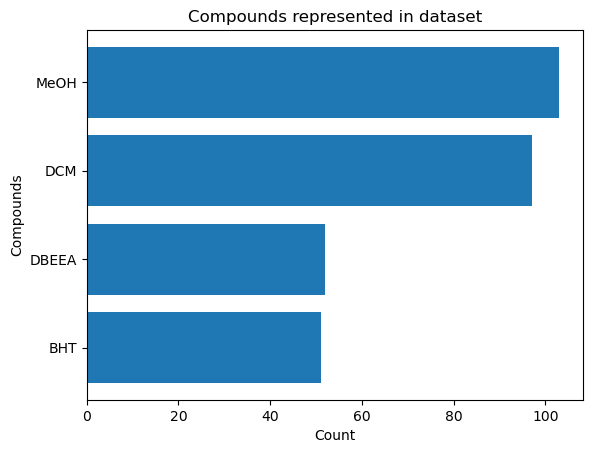

In [37]:
# Create a new DataFrame with compound counts
compound_counts = all_labels.iloc[:, 1:].sum().sort_values(ascending=True)

# Plot the horizontal bar graph
plt.barh(compound_counts.index, compound_counts.values)
plt.xlabel('Count')
plt.ylabel('Compounds')
plt.title('Compounds represented in dataset')
plt.show()


# Repeat for all samples by changing the file name

In [38]:
# Define the source folder (master list) and destination folders (train_features, test_features)
source_folder = os.path.join(data_directory, "all_features")
train_folder = os.path.join(data_directory, "train_features")
test_folder = os.path.join(data_directory, "test_features")

# Create the destination folders if they don't exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Get the list of Excel files in the source folder
excel_files = [file for file in os.listdir(source_folder) if file.endswith(".xlsx")]

# Shuffle the list of files
random.shuffle(excel_files)

# Determine the split point for train/test
split_point = int(len(excel_files) * 0.8)  # 80% for training, 20% for testing

# Split the files into train and test
train_files = excel_files[:split_point]
test_files = excel_files[split_point:]

# Move the train files to the train folder
for file in train_files:
    source_path = os.path.join(source_folder, file)
    destination_path = os.path.join(train_folder, file)
    shutil.copy(source_path, destination_path)

# Move the test files to the test folder
for file in test_files:
    source_path = os.path.join(source_folder, file)
    destination_path = os.path.join(test_folder, file)
    shutil.copy(source_path, destination_path)

print("Train/Test split completed successfully.")

Train/Test split completed successfully.


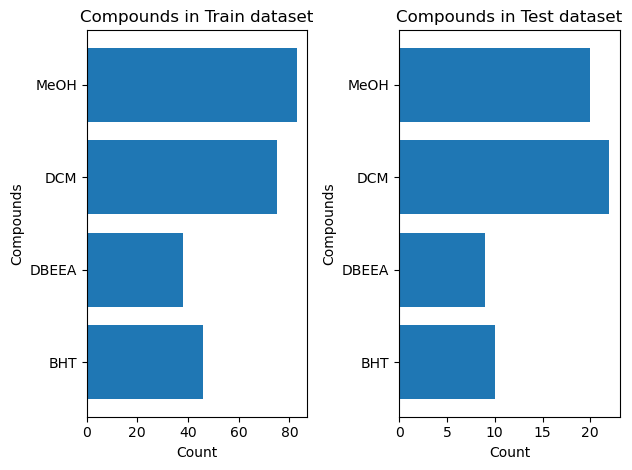

In [39]:
# Read the all_labels.csv file
all_labels = pd.read_csv(file_path , index_col=0)  # Assuming the first column is the sample id

# Create a counter to store the occurrences of column headers for train and test
train_column_occurrences = {}
test_column_occurrences = {}

# Function to count the occurrences of column headers
def count_column_occurrences(file_name, column_occurrences):
    # Check if the file name exists in all_labels
    if file_name in all_labels.index:
        # Get the columns with value 1 for the corresponding file
        columns = all_labels.columns[all_labels.loc[file_name] == 1]

        # Iterate over the columns and count the occurrences of column headers
        for column in columns:
            column_header = all_labels.columns[all_labels.loc[file_name] == 1][0]
            if column_header in column_occurrences:
                column_occurrences[column_header] += 1
            else:
                column_occurrences[column_header] = 1

# Iterate over the files in the train folder
for file in os.listdir(train_folder):
    if file.endswith(".xlsx"):
        # Remove the file extension
        file_name = os.path.splitext(file)[0]
        count_column_occurrences(file_name, train_column_occurrences)

# Iterate over the files in the test folder
for file in os.listdir(test_folder):
    if file.endswith(".xlsx"):
        # Remove the file extension
        file_name = os.path.splitext(file)[0]
        count_column_occurrences(file_name, test_column_occurrences)

# Plot the horizontal bar chart for train
plt.subplot(1, 2, 1)
plt.barh(list(train_column_occurrences.keys()), list(train_column_occurrences.values()))
plt.xlabel('Count')
plt.ylabel('Compounds')
plt.title('Compounds in Train dataset')

# Plot the horizontal bar chart for test
plt.subplot(1, 2, 2)
plt.barh(list(test_column_occurrences.keys()), list(test_column_occurrences.values()))
plt.xlabel('Count')
plt.ylabel('Compounds')
plt.title('Compounds in Test dataset')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [42]:
# Get the list of files in the train_folder directory
files = os.listdir(train_folder)

# Extract file names without the extension and store them in file_names list
file_names = [os.path.splitext(file)[0] for file in files]

# Create the train_labels and test_labels DataFrame
train_labels = pd.DataFrame(columns=all_labels.columns)
test_labels = pd.DataFrame(columns=all_labels.columns)

# Set the index header
train_labels.index.name = "sample id"
test_labels.index.name = "sample id"

# Copy rows that match the values in file_names into train_labels
train_labels = pd.concat([train_labels, all_labels.loc[file_names]], axis=0)

# Copy rows that are not in file_names into test_labels
test_labels = pd.concat([test_labels, all_labels.loc[~all_labels.index.isin(file_names)]], axis=0)

# Define the file paths
train_labels_path = os.path.join(data_directory, 'train_labels.csv')
test_labels_path = os.path.join(data_directory, 'test_labels.csv')

# Save train_labels in the data_directory folder
train_labels.to_csv(train_labels_path)

# Save test_labels in the data_directory folder
test_labels.to_csv(test_labels_path)


# Start of feature engineering

In [43]:
PROJ_ROOT = Path.cwd().parent
DATA_PATH = PROJ_ROOT / "MAIN CODE/data"

In [49]:
metadata = pd.read_csv(DATA_PATH / "all_labels.csv", index_col="sample id")
metadata.head()

,BHT,DBEEA,DCM,MeOH
sample id,,,,
sample_000001,1.0,0.0,0.0,0.0
sample_000002,1.0,0.0,0.0,0.0
sample_000003,1.0,0.0,0.0,0.0
sample_000004,1.0,0.0,0.0,0.0
sample_000005,1.0,0.0,0.0,0.0


In [50]:
sample_indices = [1, 47, 94, 191, 294] #these indices are specifically for the 5 unique combination of compounds
sample_ids_ls = metadata.index[sample_indices].values

# Import datasets for EDA (Exploratory Data Analysis)
sample_data_dict = {}

for sample_id in tqdm(sample_ids_ls, desc='Processing'):
    sample_data_dict[sample_id] = pd.read_excel(DATA_PATH / 'all_features' / (sample_id + ".xlsx"))

Processing: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [01:54<00:00, 22.95s/it]


In [51]:
def plot_spectrogram(sample_df, sample_lab):

    # For visual clarity, we will round these intensity values to the nearest whole number and average the intensity.
    sample_df["m/z"] = sample_df["m/z"].round()
    sample_df = (
        sample_df.groupby(["scan time", "m/z"])["intensity"].aggregate("mean").reset_index()
    )

    for m in sample_df["m/z"].unique():
        plt.plot(
            sample_df[sample_df["m/z"] == m]["scan time"],
            sample_df[sample_df["m/z"] == m]["intensity"],
        )

    plt.title(sample_lab)

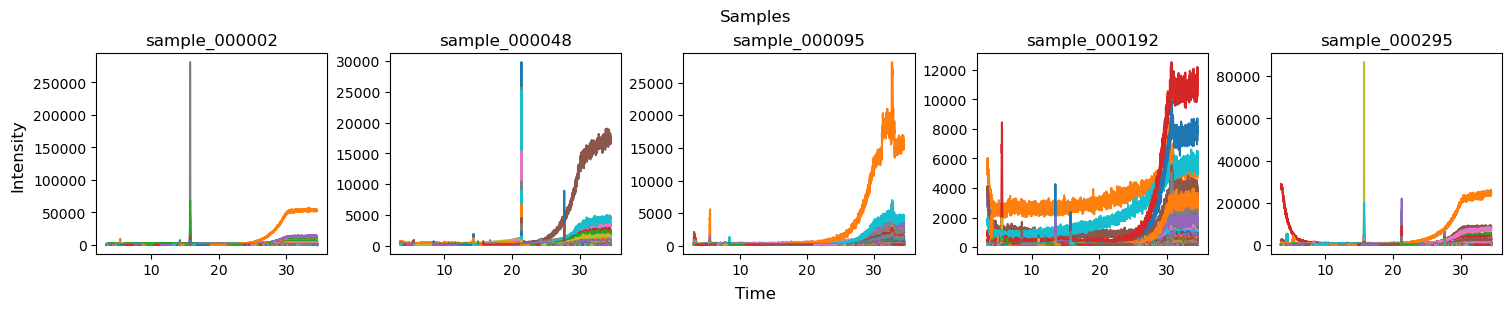

In [52]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3), constrained_layout=True)
fig.suptitle("Samples")
fig.supxlabel("Time")
fig.supylabel("Intensity")

for i in range(0, 5):
    sample_lab = sample_ids_ls[i]
    sample_df = sample_data_dict[sample_lab]

    plt.subplot(1, 5, i + 1)
    plot_spectrogram(sample_df, sample_lab)

# Finetuning of factors can be further explored
# Smaller time bin -> Higher accuracy up to a certain extent(?), however more time will be needed to train the model. 
# Upper limit of 400 is set for the m/z as analytes of interest do not extend up to that range.
# Hence size of data would include: 
# (35/0.25) time bins * 400 rounded m/z = 56000 feature rows per sample

In [53]:
# Create a series of time bins
timerange = pd.interval_range(start=0, end=35, freq=0.25)
timerange

# Make dataframe with rows that are combinations of all temperature bins and all m/z values
allcombs = list(itertools.product(timerange, [*range(1, 401)]))

allcombs_df = pd.DataFrame(allcombs, columns=["time bin", "rounded m/z"])
print(allcombs_df)

            time bin  rounded m/z
0        (0.0, 0.25]            1
1        (0.0, 0.25]            2
2        (0.0, 0.25]            3
3        (0.0, 0.25]            4
4        (0.0, 0.25]            5
...              ...          ...
55995  (34.75, 35.0]          396
55996  (34.75, 35.0]          397
55997  (34.75, 35.0]          398
55998  (34.75, 35.0]          399
55999  (34.75, 35.0]          400

[56000 rows x 2 columns]


# Online literature normalises the abundance against the max in the entire sample run 
# This code normalises against the max in the same scan number
# Possible change to be implemented here and in the preprocessing step at the start as mentioned previously

In [54]:
def int_per_timebin(df):

    """
    Transforms dataset to take the preprocessed max abundance for each
    time range for each m/z value

    Args:
        df: dataframe to transform

    Returns:
        transformed dataframe
    """

    # Bin times
    df["time bin"] = pd.cut(df["scan time"], bins=timerange)

    # Combine with a list of all time bin-m/z value combinations
    df = pd.merge(allcombs_df, df, on=["time bin", "rounded m/z"], how="left")

    # Aggregate to time bin level to find max
    df = df.groupby(["time bin", "rounded m/z"]).max("normalised intensity").reset_index()

    # Fill in 0 for intensity values without information
    df = df.replace(np.nan, 0)

    # Reshape so each row is a single sample
    df = df.pivot_table(
        columns=["rounded m/z", "time bin"], values=["normalised intensity"]
    )

    return df

In [55]:
file_dict = {file_name[:-5]: "train_features\\" + file_name for file_name in train_files}

In [56]:
# Assembling preprocessed and transformed training set

train_features_dict = {}
print("Total number of train files: ", len(file_dict))

for i, (sample_id, filepath) in enumerate(tqdm(file_dict.items())):
    # Load training sample
    temp = pd.read_excel(os.path.join(data_directory, filepath))

    # Feature engineering
    train_sample_fe = int_per_timebin(temp).reset_index(drop=True)
    train_features_dict[sample_id] = train_sample_fe

train_features = pd.concat(
    train_features_dict, names=["sample id", "dummy index"]
).reset_index(level="dummy index", drop=True)


Total number of train files:  238


100%|██████████████████████████████████████████████████████████████████████████████| 238/238 [1:27:47<00:00, 22.13s/it]


In [164]:
train_features = train_features.sort_index(ascending=True)
train_features.head()

rounded m/z           1                                                    \
time bin      (0.0, 0.25] (0.25, 0.5] (0.5, 0.75] (0.75, 1.0] (1.0, 1.25]   
sample id                                                                   
sample_000001         0.0         0.0         0.0         0.0         0.0   
sample_000002         0.0         0.0         0.0         0.0         0.0   
sample_000004         0.0         0.0         0.0         0.0         0.0   
sample_000005         0.0         0.0         0.0         0.0         0.0   
sample_000007         0.0         0.0         0.0         0.0         0.0   

rounded m/z                                                                \
time bin      (1.25, 1.5] (1.5, 1.75] (1.75, 2.0] (2.0, 2.25] (2.25, 2.5]   
sample id                                                                   
sample_000001         0.0         0.0         0.0         0.0         0.0   
sample_000002         0.0         0.0         0.0         0.0         0.0   
sample_000004         0.0         0.0         0.0         0.0         0.0   
sample_000005         0.0         0.0         0.0         0.0         0.0   
sample_000007         0.0         0.0         0.0         0.0         0.0   

rounded m/z    ...           400                                            \
time bin       ... (32.5, 32.75] (32.75, 33.0] (33.0, 33.25] (33.25, 33.5]   
sample id      ...                                                           
sample_000001  ...      0.000000           0.0           0.0           0.0   
sample_000002  ...      0.003206           0.0           0.0           0.0   
sample_000004  ...      0.000000           0.0           0.0           0.0   
sample_000005  ...      0.000000           0.0           0.0           0.0   
sample_000007  ...      0.000000           0.0           0.0           0.0   

rounded m/z                                                            \
time bin      (33.5, 33.75] (33.75, 34.0] (34.0, 34.25] (34.25, 34.5]   
sample id                                                               
sample_000001           0.0           0.0           0.0           0.0   
sample_000002           0.0           0.0           0.0           0.0   
sample_000004           0.0           0.0           0.0           0.0   
sample_000005           0.0           0.0           0.0           0.0   
sample_000007           0.0           0.0           0.0           0.0   

rounded m/z                                
time bin      (34.5, 34.75] (34.75, 35.0]  
sample id                                  
sample_000001           0.0           0.0  
sample_000002           0.0           0.0  
sample_000004           0.0           0.0  
sample_000005           0.0           0.0  
sample_000007           0.0           0.0  

[5 rows x 56000 columns]

# Backup of main feature file (.csv and .parquet) 

In [165]:
# Save train_features in the data_directory folder
train_features.to_csv(os.path.join(data_directory, 'train_features.csv'), index=True)

In [166]:
# Create a temporary copy of the original DataFrame
temp_df = train_features.copy()
temp_df.columns = [str(col) for col in temp_df.columns]
# Save temp_df in the data_directory folder
temp_df.to_parquet(os.path.join(data_directory, 'train_features.parquet'))

In [167]:
# Make sure that all sample IDs in features and labels are identical
assert train_features.index.equals(train_labels.index)

# Start of logistic regression

In [168]:
# Define stratified k-fold validation
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Define log loss
log_loss_scorer = make_scorer(log_loss, needs_proba=True)

In [169]:
# Check log loss score for baseline dummy model
def logloss_cross_val(clf, X, y):

    # Generate a score for each label class
    log_loss_cv = {}
    for col in y.columns:

        y_col = y[col]  # take one label at a time
        log_loss_cv[col] = np.mean(
            cross_val_score(clf, X.values, y_col, cv=skf, scoring=log_loss_scorer)
        )

    avg_log_loss = np.mean(list(log_loss_cv.values()))

    return log_loss_cv, avg_log_loss

In [171]:
target_cols = train_labels.columns.tolist()

# Dummy classifer gives a baseline by "prior" strategy which is basically just probabiliy guessing through the distribution of labels present
# The lower the log-loss, the better the model

In [172]:
# Dummy classifier
dummy_clf = DummyClassifier(strategy="prior")

print("Dummy model cross-validation average log-loss:")
dummy_logloss = logloss_cross_val(dummy_clf, train_features, train_labels[target_cols])
pprint(dummy_logloss[0])
print("\nAggregate log-loss")
dummy_logloss[1]

Dummy model cross-validation average log-loss:
{'BHT': 0.43216121176395517,
 'DBEEA': 0.49696326375093314,
 'DCM': 0.6295656668645293,
 'MeOH': 0.6440642139448889}

Aggregate log-loss


0.5506885890810767

# Using a pre-trained logistic regression model instead

In [173]:
# Define Lasso model
logreg_clf = LogisticRegression(penalty="l1", solver="liblinear", C=2)
print("Logistic regression model cross-validation average log-loss:\n")
logreg_logloss = logloss_cross_val(logreg_clf, train_features, train_labels[target_cols])
pprint(logreg_logloss[0])
print("Aggregate log-loss")
logreg_logloss[1]

Logistic regression model cross-validation average log-loss:

{'BHT': 0.0655759937977961,
 'DBEEA': 0.06009590942860663,
 'DCM': 0.06841955730278344,
 'MeOH': 0.12280827916547073}
Aggregate log-loss


0.07922493492366423

# Modelling of logistic regression based off our data

In [174]:
# Train logistic regression model with l1 regularization, where C = 2
def logreg_train(X_train, y_train):

    # Initialize dict to hold fitted models
    logreg_model_dict = {}

    # Split into binary classifier for each class
    for col in y_train.columns:

        y_train_col = y_train[col]  # Train on one class at a time

        # Output the trained model, bind this to a var, then use as input to prediction function
        clf = LogisticRegression(penalty="l1", solver="liblinear", C=2, random_state=42)

        logreg_model_dict[col] = clf.fit(X_train.values, y_train_col)  # Train

    return logreg_model_dict

In [175]:
fitted_logreg_dict = logreg_train(train_features, train_labels[target_cols])


# Testing our model